# Step 3 - Fine-tuning the Model

In [Step 2 - Choosing a Model](Step 2 - Choosing a Model.ipynb), we settled on using a pre-trained model called **InceptionV3**.

In this notebook, we take this model and fine-tune some parameters to see which combination achieves the best results. Like before, we will use the *F1 Score* metric to determine which model performs best.
![title](notebook_images/f1_formula.jpg)

In [1]:
# import dependencies
from image_preprocessor import ImagePreprocessor

import numpy as np
import random
import os
import shutil
from glob import glob

from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image as Image

from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

import keras.callbacks as callbacks
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.callbacks import TensorBoard

import re
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
root_dir = os.path.join('..', 'application', 'images')
originals_dir = os.path.join(root_dir, "original")
training_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
val_dir = os.path.join(root_dir, "validation")

target_imagesize = (256, 256)

clear_existing_data = True # if true, data in training, test and validation directories will be deleted before splitting the data in the originals directory
augment_data = True # whether images should be augmented during preprocessing
augmentations = 20 # how many augmentations to make for each original image

random_seed = 7

epochs = 3
batch_size = 50
saved_models_dir = os.path.join('..', 'application', 'saved_models')

In [3]:
preprocessor = ImagePreprocessor()
preprocessor.root_dir = root_dir
preprocessor.originals_dir = originals_dir
preprocessor.training_dir = training_dir
preprocessor.test_dir = test_dir
preprocessor.val_dir = val_dir
preprocessor.random_seed = random_seed
preprocessor.target_imagesize = target_imagesize
preprocessor.clear_existing_data = clear_existing_data

preprocessor.initialize()
categories = preprocessor.categories
training_count = preprocessor.training_count
validation_count = preprocessor.validation_count
test_count = preprocessor.test_count

6 image categories
465 total images

279 training images
93 validation images
93 test images

Categories:
  - animal
  - city_scape
  - food
  - group
  - landscape
  - me


In [4]:
img_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='reflect')

train_generator = img_datagen.flow_from_directory(training_dir,
                                                   target_size=target_imagesize,
                                                   batch_size=augmentations,
                                                   shuffle=True,
                                                   seed=random_seed)

validation_generator = img_datagen.flow_from_directory(val_dir,
                                                   target_size=target_imagesize,
                                                   batch_size=augmentations,
                                                   shuffle=True,
                                                   seed=random_seed)

Found 279 images belonging to 6 classes.
Found 93 images belonging to 6 classes.


In [5]:
def predict_category(img_path, pred_model):
    img_tensor = preprocessor.file_to_tensor(img_path)
    h = pred_model.predict(img_tensor)
    return categories[np.argmax(h)]

In [6]:
def f1_score_cal(model=None):
    test_images = np.array(glob(os.path.join(test_dir, "*", "*")))
    y_true = []
    y_pred = []
    for img in test_images:
        y_true.append(categories.index(re.split(r'[\\/]',img)[-2]))
        pred = predict_category(img, model)
        y_pred.append(categories.index(pred))
    
    return f1_score(y_true, y_pred, average='weighted')

In [8]:
models = []
modelnames = []
f1_scores = []

# Hidden Layer Sizes

In the section below, we will train the model with different sizes of the hidden layer:
- 16 nodes
- 32 nodes
- 64 nodes
- 128 nodes
- 256 nodes
- 512 nodes
- 1024 nodes

In [9]:
for nodes in [16, 32, 64, 128, 256, 512, 1024]:
    modelname = 'inceptionv3_' + str(nodes) + 'nodes'
    print(modelname)
    checkpointer = ModelCheckpoint(filepath=os.path.join(saved_models_dir, modelname + '.hdf5'), 
                           verbose=1, save_best_only=True)
    
    model = InceptionV3(include_top=False, weights = 'imagenet', input_shape = (target_imagesize[0], target_imagesize[1], 3))
    for layer in model.layers:
        layer.trainable = False
        
    # custom Layers 
    cus_layers = model.output
    cus_layers = Flatten()(cus_layers)
    
    cus_layers = Dense(nodes, activation="relu")(cus_layers)
    predictions = Dense(len(categories), activation="softmax")(cus_layers)
    
    model_final = Model(inputs = model.input, outputs = predictions)
    model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])
    # train the model
    model_final.fit_generator(train_generator,
                             steps_per_epoch=training_count // epochs, 
                              epochs=epochs,
                             validation_data = validation_generator,
                             validation_steps=validation_count // epochs,
                             callbacks=[checkpointer],
                             verbose=1)
    
    model_final.load_weights(filepath=os.path.join(saved_models_dir, modelname + '.hdf5'))
    
    models.append(model_final)
    modelnames.append(modelname)

inceptionv3_16nodes
Epoch 1/3
92/93 [============================>.] - ETA: 1s - loss: 1.0129 - acc: 0.6368

C:\Users\donke\Anaconda2\envs\cnn_image_classification\lib\site-packages\PIL\Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch 00000: val_loss improved from inf to 0.65292, saving model to saved_models\inceptionv3_16nodes.hdf5
93/93 [==============================] - 136s - loss: 1.0064 - acc: 0.6386 - val_loss: 0.6529 - val_acc: 0.7976
Epoch 2/3
93/93 [==============================] - 121s - loss: 0.4091 - acc: 0.8581 - val_loss: 0.5677 - val_acc: 0.8183
Epoch 3/3
93/93 [==============================] - 116s - loss: 0.3489 - acc: 0.8888 - val_loss: 0.4871 - val_acc: 0.8406
inceptionv3_32nodes
Epoch 1/3
93/93 [==============================] - 136s - loss: 0.9971 - acc: 0.6372 - val_loss: 0.6502 - val_acc: 0.7993
Epoch 2/3
93/93 [==============================] - 118s - loss: 0.3874 - acc: 0.8695 - val_loss: 0.6600 - val_acc: 0.7803
Epoch 3/3
93/93 [==============================] - 117s - loss: 0.2846 - acc: 0.9060 - val_loss: 0.5445 - val_acc: 0.8374
inceptionv3_64nodes
Epoch 1/3
93/93 [==============================] - 148s - loss: 1.0036 - acc: 0.6566 - val_loss: 0.6600 - val_acc: 0.7820
Epoch 2/3


## Scoring the models

Now that all variations of the model have been trained, we can calculate their respective F1 scores to see if any of them stand out in terms of performance.

In [10]:
for i, model in enumerate(models):
    f1score = f1_score_cal(model)
    f1_scores.append(f1score)
    print(modelnames[i], f1score)

inceptionv3_16nodes 0.808412667198
inceptionv3_32nodes 0.801847841651
inceptionv3_64nodes 0.816557286497
inceptionv3_128nodes 0.818479896273
inceptionv3_256nodes 0.858061936774
inceptionv3_512nodes 0.832240186162
inceptionv3_1024nodes 0.826741946941


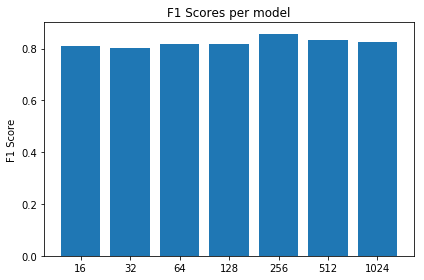

In [11]:
fig, ax = plt.subplots()

index = np.arange(7)

rects1 = ax.bar(index, f1_scores)

ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores per model')
ax.set_xticks(index)
ax.set_xticklabels([16, 32, 64, 128, 256, 512, 1024])

fig.tight_layout()
plt.show()

## Conclusion

The size of the hidden layer seems to be arbitrary as their results don't vary much at all. All variations took around the same time to train (between 5 and 10 minutes), so we'll just choose the layer size that gave the best result in terms of F1 score; **256 nodes** in the hidden layer.

# Dropout Values

We want our model to be able to look at an image and predict what category the image should be in. We don't want our model to just memorize the images it has seen in the training phase.

When a model starts memorizing images rather than learning generic features, it starts to overfit. It will have excellent results on images in the training set, but it might not be able to categorize images it hasn't seen before.

One way to combat this, is by adding a **dropout layer**. With a dropout layer, we take a percentage of random nodes for each step and deactivate them. This way, the model is forced to 'forget' some of the information it learned.

![title](notebook_images/nodropout_vs_dropout.jpg)

In [9]:
models = []
modelnames = []
f1_scores = []
for d in [0.1, 0.2, 0.4, 0.5, 0.8]:
    model = load_model(os.path.join('saved_models', 'inceptionv3_256nodes.hdf5'))
    modelname = 'inceptionv3_256nodes_' + str(d) + 'dropout'
    print(modelname)
    checkpointer = ModelCheckpoint(filepath=os.path.join(saved_models_dir, modelname + '.hdf5'), 
                           verbose=1, save_best_only=True)
    
    model = InceptionV3(include_top=False, weights = 'imagenet', input_shape = (target_imagesize[0], target_imagesize[1], 3))
    for layer in model.layers:
        layer.trainable = False
        
    # custom Layers 
    cus_layers = model.output
    cus_layers = Flatten()(cus_layers)
    
    cus_layers = Dense(256, activation="relu")(cus_layers)
    cus_layers = Dropout(d)(cus_layers)
    predictions = Dense(len(categories), activation="softmax")(cus_layers)
    
    model_final = Model(inputs = model.input, outputs = predictions)
    model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])
    # train the model
    model_final.fit_generator(train_generator,
                             steps_per_epoch=training_count // epochs, 
                              epochs=epochs,
                             validation_data = validation_generator,
                             validation_steps=validation_count // epochs,
                             callbacks=[checkpointer],
                             verbose=1)
    
    model_final.load_weights(filepath=os.path.join(saved_models_dir, modelname + '.hdf5'))
    
    models.append(model_final)
    modelnames.append(modelname)

inceptionv3_256nodes_0.1dropout
Epoch 1/3
92/93 [============================>.] - ETA: 0s - loss: 0.9991 - acc: 0.6591

C:\Users\donke\Anaconda2\envs\cnn_image_classification\lib\site-packages\PIL\Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch 00000: val_loss improved from inf to 0.65562, saving model to saved_models\inceptionv3_256nodes_0.1dropout.hdf5
93/93 [==============================] - 137s - loss: 0.9955 - acc: 0.6612 - val_loss: 0.6556 - val_acc: 0.8149
Epoch 2/3
93/93 [==============================] - 118s - loss: 0.3912 - acc: 0.8786 - val_loss: 0.5480 - val_acc: 0.8304
Epoch 3/3
93/93 [==============================] - 117s - loss: 0.3450 - acc: 0.8844 - val_loss: 0.5197 - val_acc: 0.8284
inceptionv3_256nodes_0.2dropout
Epoch 1/3
93/93 [==============================] - 150s - loss: 1.0048 - acc: 0.6481 - val_loss: 0.6327 - val_acc: 0.7924
Epoch 2/3
93/93 [==============================] - 119s - loss: 0.4392 - acc: 0.8500 - val_loss: 0.6360 - val_acc: 0.8114
Epoch 3/3
93/93 [==============================] - 118s - loss: 0.3397 - acc: 0.8769 - val_loss: 0.5482 - val_acc: 0.8218
inceptionv3_256nodes_0.4dropout
Epoch 1/3
93/93 [==============================] - 172s - loss: 1.1463 - acc: 0.5945 - val_loss:

## Scoring the models

Like before, we will calculate the F1 scores on the new set of models to determine which one performs the best.

In [11]:
for i, model in enumerate(models):
    f1score = f1_score_cal(model)
    f1_scores.append(f1score)
    print(modelnames[i], f1score)

inceptionv3_256nodes_0.1dropout 0.826881712703
inceptionv3_256nodes_0.2dropout 0.830371429256
inceptionv3_256nodes_0.4dropout 0.844036058827
inceptionv3_256nodes_0.5dropout 0.831721006114
inceptionv3_256nodes_0.8dropout 0.850815913088


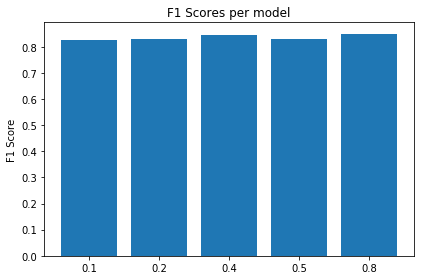

In [13]:
fig, ax = plt.subplots()

index = np.arange(5)

rects1 = ax.bar(index, f1_scores)

ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores per model')
ax.set_xticks(index)
ax.set_xticklabels([0.1, 0.2, 0.4, 0.5, 0.8])

fig.tight_layout()
plt.show()

## Conclusion

Like the amount of nodes in the hidden layer, the amount of dropout seems to be arbitrary as well. It might be because the dataset is relatively small, so it never gets a chance to overfit.

We'll choose a dropout that's somewhere in the middle of the range; **0.4**, which achieved an F1 score of *0.844*.